# Import Libraries

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [163]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_repeated=0, random_state=SEED)

del y

In [164]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X.shape

(1000, 2)

In [167]:
df = pd.DataFrame(X, columns=['x1','x2'])
df['f'] = (df['x1']-0.1)**2 + 4*(df['x2']-0.1)**2 - 0.52 < 0
df.head(3)

,x1,x2,f
0,0.362357,0.453026,False
1,0.649118,0.665254,False
2,0.612866,0.630900,False


`STABILITY INDICATOR`

In [168]:
len(df[df['f']==1])/len(df)

0.196

Προσπαθούμε να εξάγουμε κανόνες από τα Χ ώστε να ικανοποιείται η συνθήκη `f`.

In [169]:
X = df.drop(columns='f')
y = df['f']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=SEED)

In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.99

In [172]:
model.feature_importances_

array([0.35606327, 0.64393673])

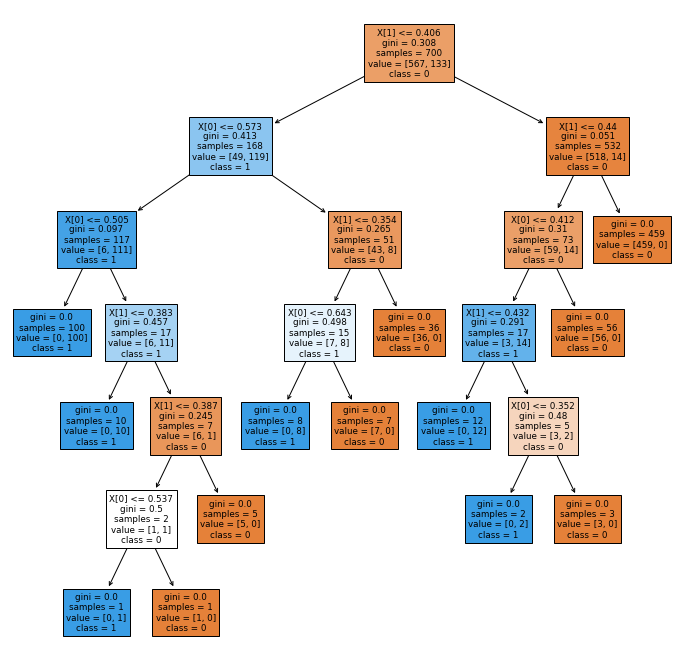

In [173]:
from sklearn import tree

plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(model, filled=True, class_names=['0','1'])
plt.show()

In [174]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [175]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [178]:
rules = get_rules(model, feature_names=['x_1','x_2'], class_names=['False','True'])
for r in rules:
    print(r)

if (x_2 > 0.406) and (x_2 > 0.44) then class: False (proba: 100.0%) | based on 459 samples
if (x_2 <= 0.406) and (x_1 <= 0.573) and (x_1 <= 0.505) then class: True (proba: 100.0%) | based on 100 samples
if (x_2 > 0.406) and (x_2 <= 0.44) and (x_1 > 0.412) then class: False (proba: 100.0%) | based on 56 samples
if (x_2 <= 0.406) and (x_1 > 0.573) and (x_2 > 0.354) then class: False (proba: 100.0%) | based on 36 samples
if (x_2 > 0.406) and (x_2 <= 0.44) and (x_1 <= 0.412) and (x_2 <= 0.432) then class: True (proba: 100.0%) | based on 12 samples
if (x_2 <= 0.406) and (x_1 <= 0.573) and (x_1 > 0.505) and (x_2 <= 0.383) then class: True (proba: 100.0%) | based on 10 samples
if (x_2 <= 0.406) and (x_1 > 0.573) and (x_2 <= 0.354) and (x_1 <= 0.643) then class: True (proba: 100.0%) | based on 8 samples
if (x_2 <= 0.406) and (x_1 > 0.573) and (x_2 <= 0.354) and (x_1 > 0.643) then class: False (proba: 100.0%) | based on 7 samples
if (x_2 <= 0.406) and (x_1 <= 0.573) and (x_1 > 0.505) and (x_2 >

In [199]:
x_2 = np.random.uniform(0.383, 0.387, size=100)
x_1 = np.random.uniform(0,0.573, size=100)

new_df = pd.DataFrame(columns=['x1','x2', 'f'])
new_df['x1'] = x_1
new_df['x2'] = x_2
new_df['f'] = (new_df['x1']-0.1)**2 + 4*(new_df['x2']-0.1)**2 - 0.52 < 0
new_df.head(3)

,x1,x2,f
0,0.408700,0.384040,True
1,0.289624,0.386890,True
2,0.471165,0.385176,True


`STABILITY INDICATOR`

In [201]:
len(new_df[new_df['f']==1])/len(new_df)

0.95

# FLDA

In [31]:
X, y = make_classification(n_samples=1000, n_features=5, random_state=SEED)

In [32]:
X.shape

(1000, 5)

In [33]:
from sklearn.preprocessing import StandardScaler

sc = MinMaxScaler()
X = sc.fit_transform(X)

In [ ]:
! pip install skfeature-chappers

In [46]:
from skfeature.function.similarity_based import fisher_score

ModuleNotFoundError: No module named 'skfeature'

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)

In [40]:
lda.get_params

<bound method BaseEstimator.get_params of LinearDiscriminantAnalysis(n_components=1)>

In [43]:
from skfeature.function.similarity_based import fisher_score

core = fisher_score.fisher_score(X, y)
print(score)

ModuleNotFoundError: No module named 'skfeature'